# Preprocessing pipeline 

1. [Load data](#load)
2. [Downsample](#downsample)
3. [Filters](#filters)
4. [Find events](#events)
5. [Create epochs](#epochs)
6. [Baseline correction](#baseline) 
7. [Reject bad epochs and channels using the adaptive algorithm](#reject)
8. [ICA](#ica)
   1. [EOG components](#eog)
   2. [ECG components](#ecg)
9. [Interpolate bad channels](#interpolate)
10. [Average reference](#rereference)

In [1]:
%matplotlib qt
import mne
import utils
import matplotlib.pyplot as plt

# from cleaner.report import create_ica_report 
# from cleaner import reject

# from nice_ext.algorithms.adaptive import _adaptive_egi

from autoreject import AutoReject, get_rejection_threshold

# Load data <a name="load"></a>

List of participants: 'VP07';'VP08';'VP09';'VP10';'VP11';'VP12';'VP13';'VP14';'VP18';'VP19';'VP20';'VP23';'VP24';'VP25';'VP26';'VP27';'VP28';'VP29';'VP30';'VP31';'VP32';'VP33';'VP35';'VP36';'VP37';

In [2]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

In [409]:
all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']
participant = all_participants[12]

# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

folder = path + participant +'/'
file = participant + '_crop_rMean_minmarker.set'

raw = mne.io.read_raw_eeglab(folder+file, preload = True,verbose = False)

<ipython-input-409-fe1970276064>:10: RuntimeWarning: Channel names are not unique, found duplicates for: {'C4', 'C5', 'C1', 'C3', 'C6', 'C2'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_eeglab(folder+file, preload = True,verbose = False)
<ipython-input-409-fe1970276064>:10: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(folder+file, preload = True,verbose = False)


In [410]:
corrected_chs = {'C1-0': 'C1', 'C3-0': 'C3', 'C5-0':'C5', 'C2-0': 'C2', 'C4-0':'C4', 'C6-0':'C6','C1-1':'EXG1',
 'C2-1':'EXG2',
 'C3-1':'EXG3',
 'C4-1':'EXG4',
 'C5-1':'EXG5',
 'C6-1':'EXG6',
 'C7':'EXG7',
 'C8' :'EXG8'}

raw = raw.rename_channels(corrected_chs)

In [411]:
raw.set_channel_types({'EXG3': 'eog', 'EXG4': 'eog', 'EXG5': 'eog','EXG6': 'eog','EXG1': 'eog', 'EXG2': 'eog', 'EXG7': 'eog', 'EXG8' : 'eog'})

raw = raw.pick_types(eeg = True, eog = True, exclude = ['EXG1', 'EXG2', 'EXG7', 'EXG8'])

raw = raw.set_montage('biosemi64') # ask if biosemi or 10-20 montage

print(raw.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EOG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 68
 projs: []
 sfreq: 512.0 Hz
>


In [412]:
raw.info['bads'] = []

# Downsample <a name="downsample"></a>

In [414]:
raw_downsampled = raw.copy().resample(sfreq=250)

# Filters <a name="filters"></a>
High-pass filter: 0.5Hz

Low-Pass filter: 45Hz

In [415]:
hpass = 0.5
lpass = 45

raw_filtered = raw_downsampled.copy().filter(l_freq=hpass, h_freq=lpass)

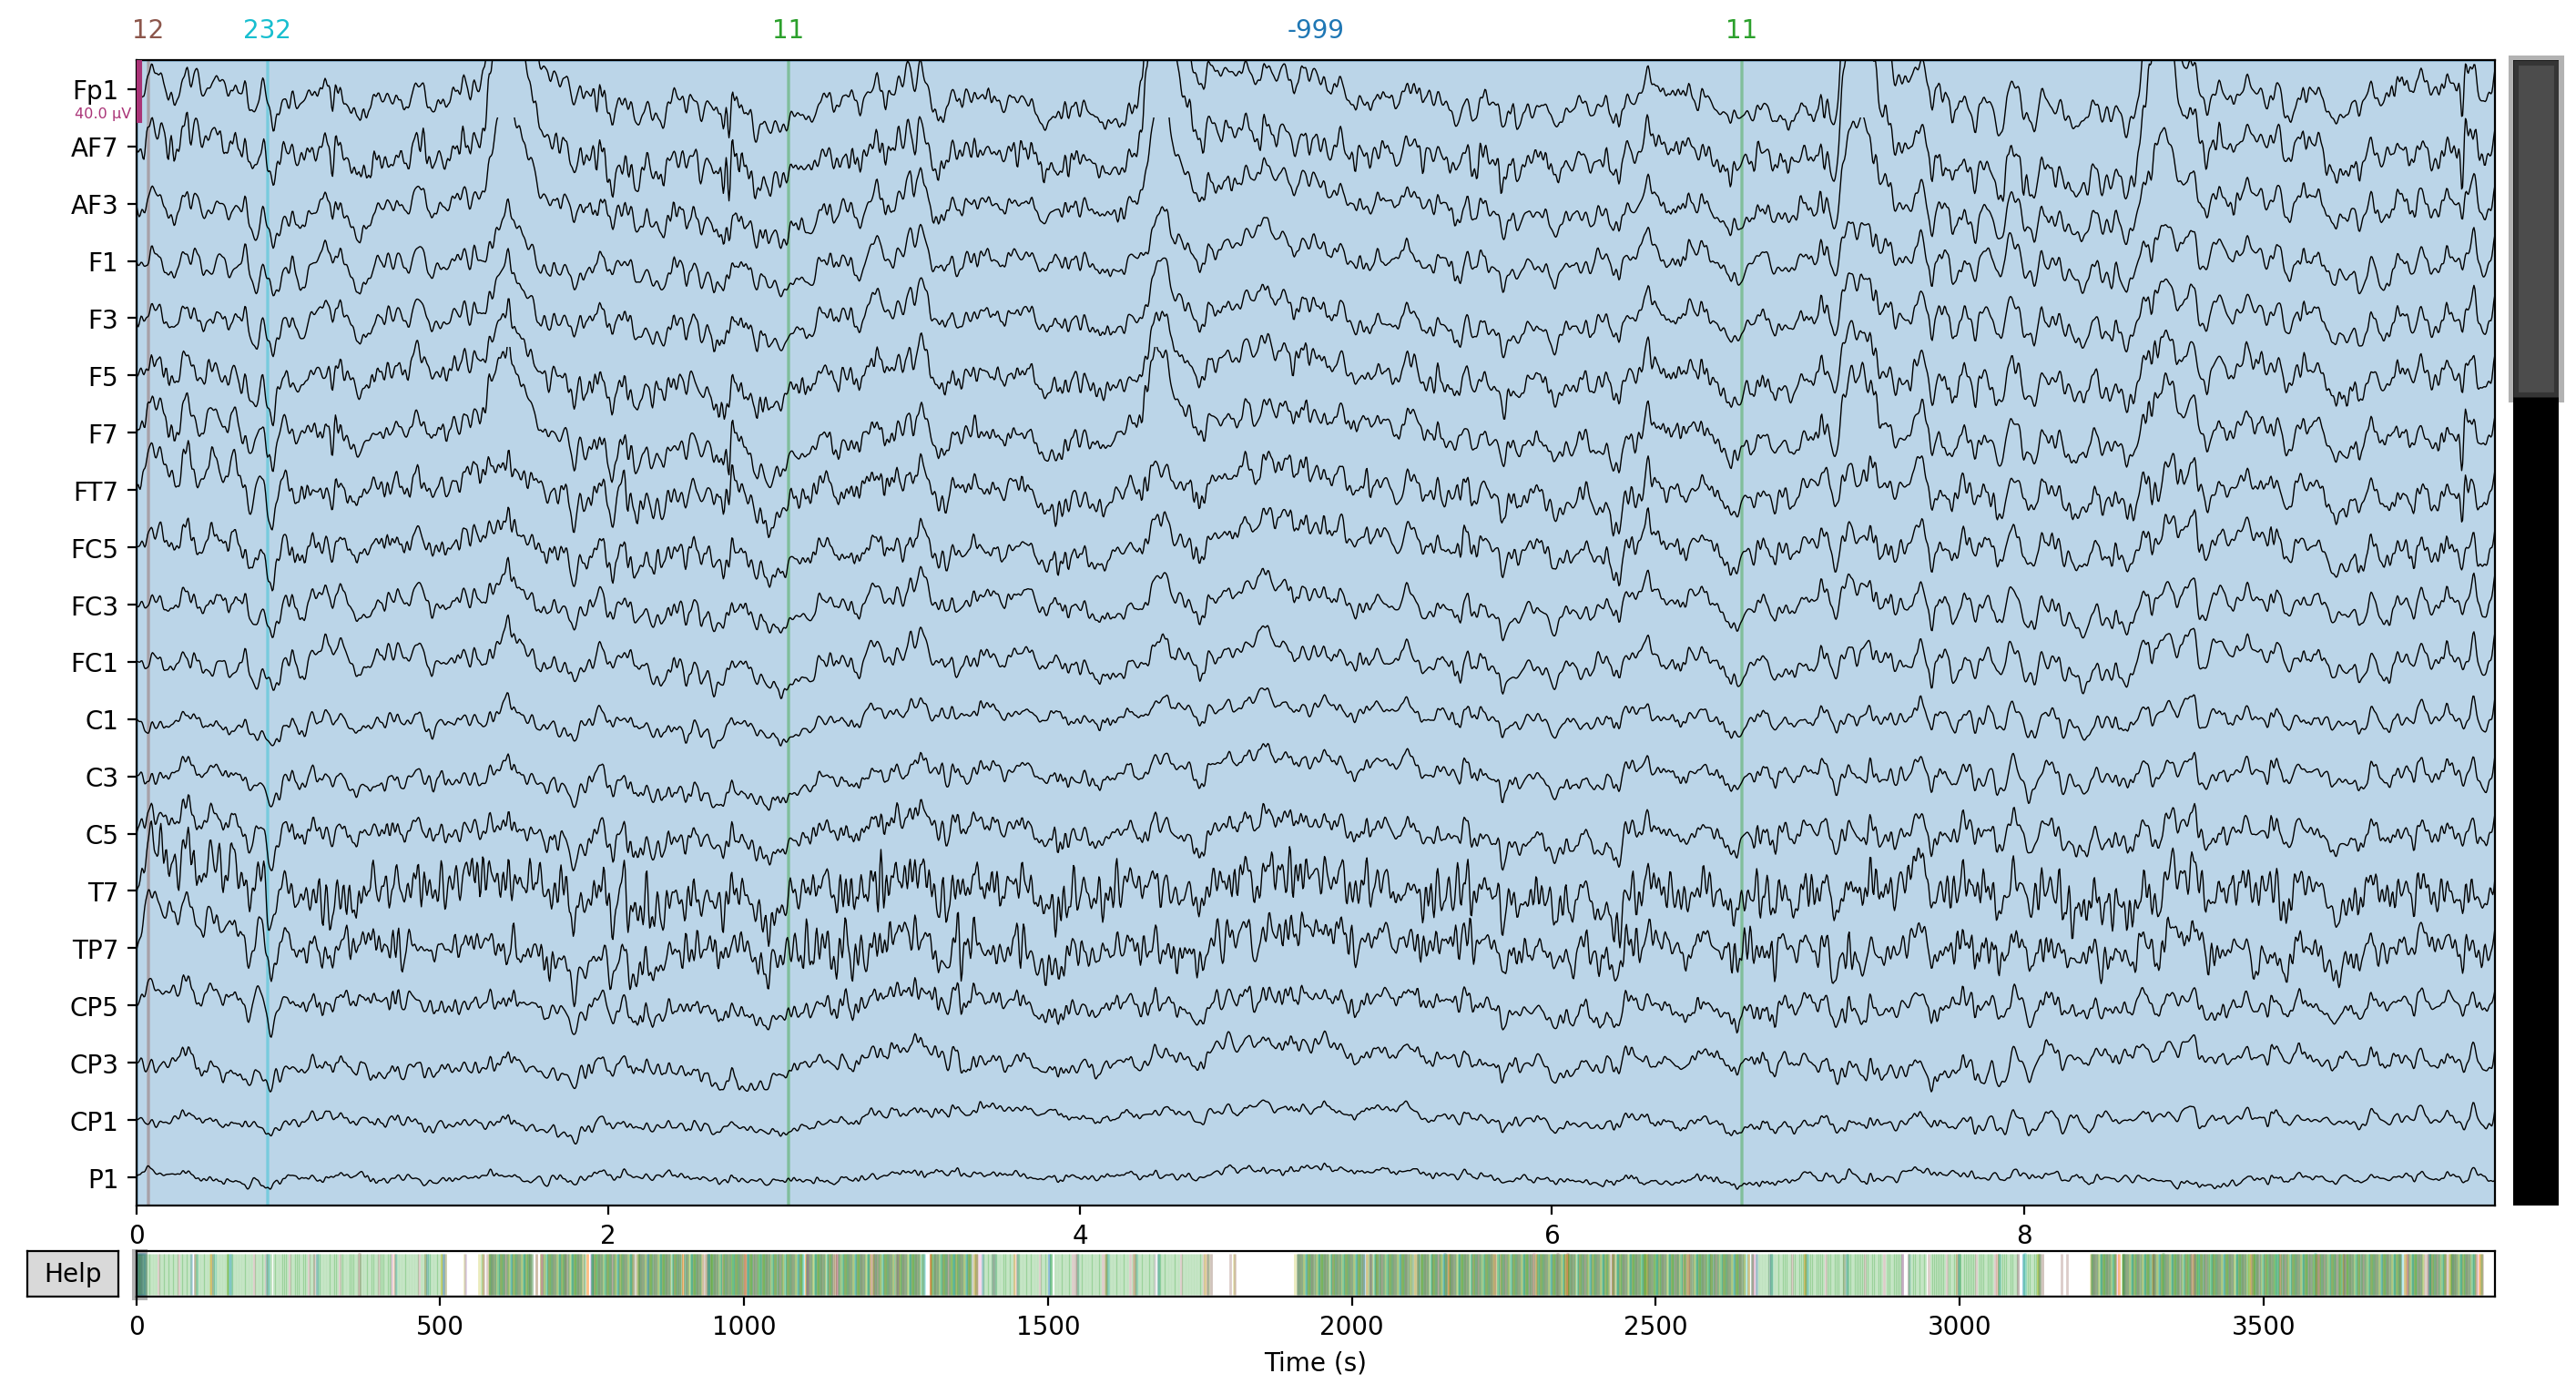

In [416]:
raw_filtered.plot()

In [417]:
### Save filtered data
raw_filtered.save(folder + participant + 'filt_raw.fif', overwrite = True)

# Find events <a name="events"></a>

In [418]:
raw_filtered = mne.io.read_raw(folder + participant + 'filt_raw.fif', preload = True)

Opening raw data file /Users/nicobruno/ownCloud/MW_eeg_data/minmarker/VP24/VP24filt_raw.fif...
    Range : 0 ... 970042 =      0.000 ...  3880.168 secs
Ready.
Reading 0 ... 970042  =      0.000 ...  3880.168 secs...


In [419]:
events, event_dict = utils.make_correct_labels(raw_filtered)

Used Annotations descriptions: ['-999', '1', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '111', '12', '167', '169', '17', '170', '171', '172', '175', '176', '177', '179', '182', '191', '2', '201', '202', '203', '204', '205', '206', '207', '208', '232', '233', '234', '237', '238', '239', '251', '252', '253', '255', '3', '4', '5', '6', '62', '68', '80', '9', '92', '98', '99']


# Create Epochs <a name="epochs"></a>

In [420]:
epochs = utils.create_epochs(epoch_type = epoch_type, raw = raw_filtered, events =  events, event_id = event_dict)
epochs.save(folder + participant + epoch_type + '_epo.fif', overwrite = True)

# Reject Bad Epochs and Channels <a name="reject"></a>

In [421]:
ar = AutoReject()
epochs_clean = ar.fit_transform(epochs)  
reject = get_rejection_threshold(epochs)  

/Users/nicobruno/opt/anaconda3/lib/python3.8/site-packages/autoreject/utils.py:63: UserWarning: 5 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(

Creating augmented epochs:   8%|▊         | 5/59 [00:00<00:01, 49.27it/s]

Running autoreject on ch_type=eeg



Creating augmented epochs: 100%|██████████| 59/59 [00:01<00:00, 55.87it/s]

Computing thresholds ...: 100%|██████████| 59/59 [00:22<00:00,  2.67it/s]


Repairing epochs:   0%|          | 0/80 [00:00<?, ?it/s]

Repairing epochs:  48%|████▊     | 38/80 [00:00<00:00, 378.25it/s]

Repairing epochs: 100%|██████████| 80/80 [00:00<00:00, 368.13it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/80 [00:00<?, ?it/s]

Repairing epochs:  11%|█▏        | 9/80 [00:00<00:00, 82.76it/s]

Repairing epochs:  22%|██▎       | 18/80 [00:00<00:00, 84.75it/s]

Repairing epochs:  32%|███▎      | 26/80 [00:00<00:00, 81.07it/s]

Repairing epochs:  45%|████▌     | 36/80 [00:00<00:00, 85.05it/s]

Repairing epochs:  56%|█████▋    | 45/80 [00:00<00:00, 84.45it/s]

Repairing epochs:  69%|██████▉   | 55/80 [00:00<00:00, 87.08it/s]

Repairing epochs:  80%|████████  | 64/80 [00:00<00:00, 86.19it/s]

Repairing epochs: 100%|██████████| 80/80 [00:00<00:00, 87.02it/s]



Fold:   0





Estimated consensus=0.60 and n_interpolate=32




Repairing epochs:  21%|██▏       | 17/80 [00:00<00:00, 80.78it/s]

Repairing epochs:  34%|███▍      | 27/80 [00:00<00:00, 85.66it/s]

Repairing epochs:  46%|████▋     | 37/80 [00:00<00:00, 88.38it/s]

Repairing epochs:  60%|██████    | 48/80 [00:00<00:00, 92.27it/s]

Repairing epochs:  72%|███████▎  | 58/80 [00:00<00:00, 94.09it/s]

Repairing epochs:  85%|████████▌ | 68/80 [00:00<00:00, 95.38it/s]

Repairing epochs: 100%|██████████| 80/80 [00:00<00:00, 91.77it/s]


Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog


In [422]:
epochs_clean.save(folder + participant + epoch_type + 'ar-clean_epo.fif', overwrite = True)

# ICA <a name="ica"></a>

In [423]:
epochs_clean = mne.read_epochs(folder + participant + epoch_type + 'ar-clean_epo.fif')
# epochs_clean.info

Reading /Users/nicobruno/ownCloud/MW_eeg_data/minmarker/VP24/VP24evokedar-clean_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated


In [425]:
n_components = 0.99  # Should normally be higher, like 0.999!!
method = 'fastica'
max_iter = 512  # Should normally be higher, like 500 or even 1000!!
fit_params = dict(fastica_it=5)
random_state = 42

ica = mne.preprocessing.ICA(n_components=n_components,
                            method=method,
                            max_iter=max_iter,
#                             fit_params=fit_params,
                            random_state=random_state)

ica.fit(epochs_clean)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by explained variance: 31 components
Fitting ICA took 0.5s.


<ICA | epochs decomposition, fit (fastica): 14874 samples, 31 components, channels used: "eeg">

In [426]:
tmin, tmax = -0.2, 0.6

baseline = (None,0)

eog_epochs = mne.preprocessing.create_eog_epochs(raw, reject=None,
                                                 baseline=baseline,
                                                 tmin=tmin, tmax=tmax)
eog_evoked = eog_epochs.average()
eog_inds, eog_scores = ica.find_bads_eog(
    eog_epochs)

# components_to_exclude = ecg_inds + eog_inds
components_to_exclude = eog_inds
ica.exclude = components_to_exclude

EOG channel index for this subject is: [64 65 66 67]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 3494 significant peaks
Number of EOG events detected : 3494
Not setting metadata
Not setting metadata
3494 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
Loading data for 3494 events and 410 original time points ...
1 bad epochs dropped


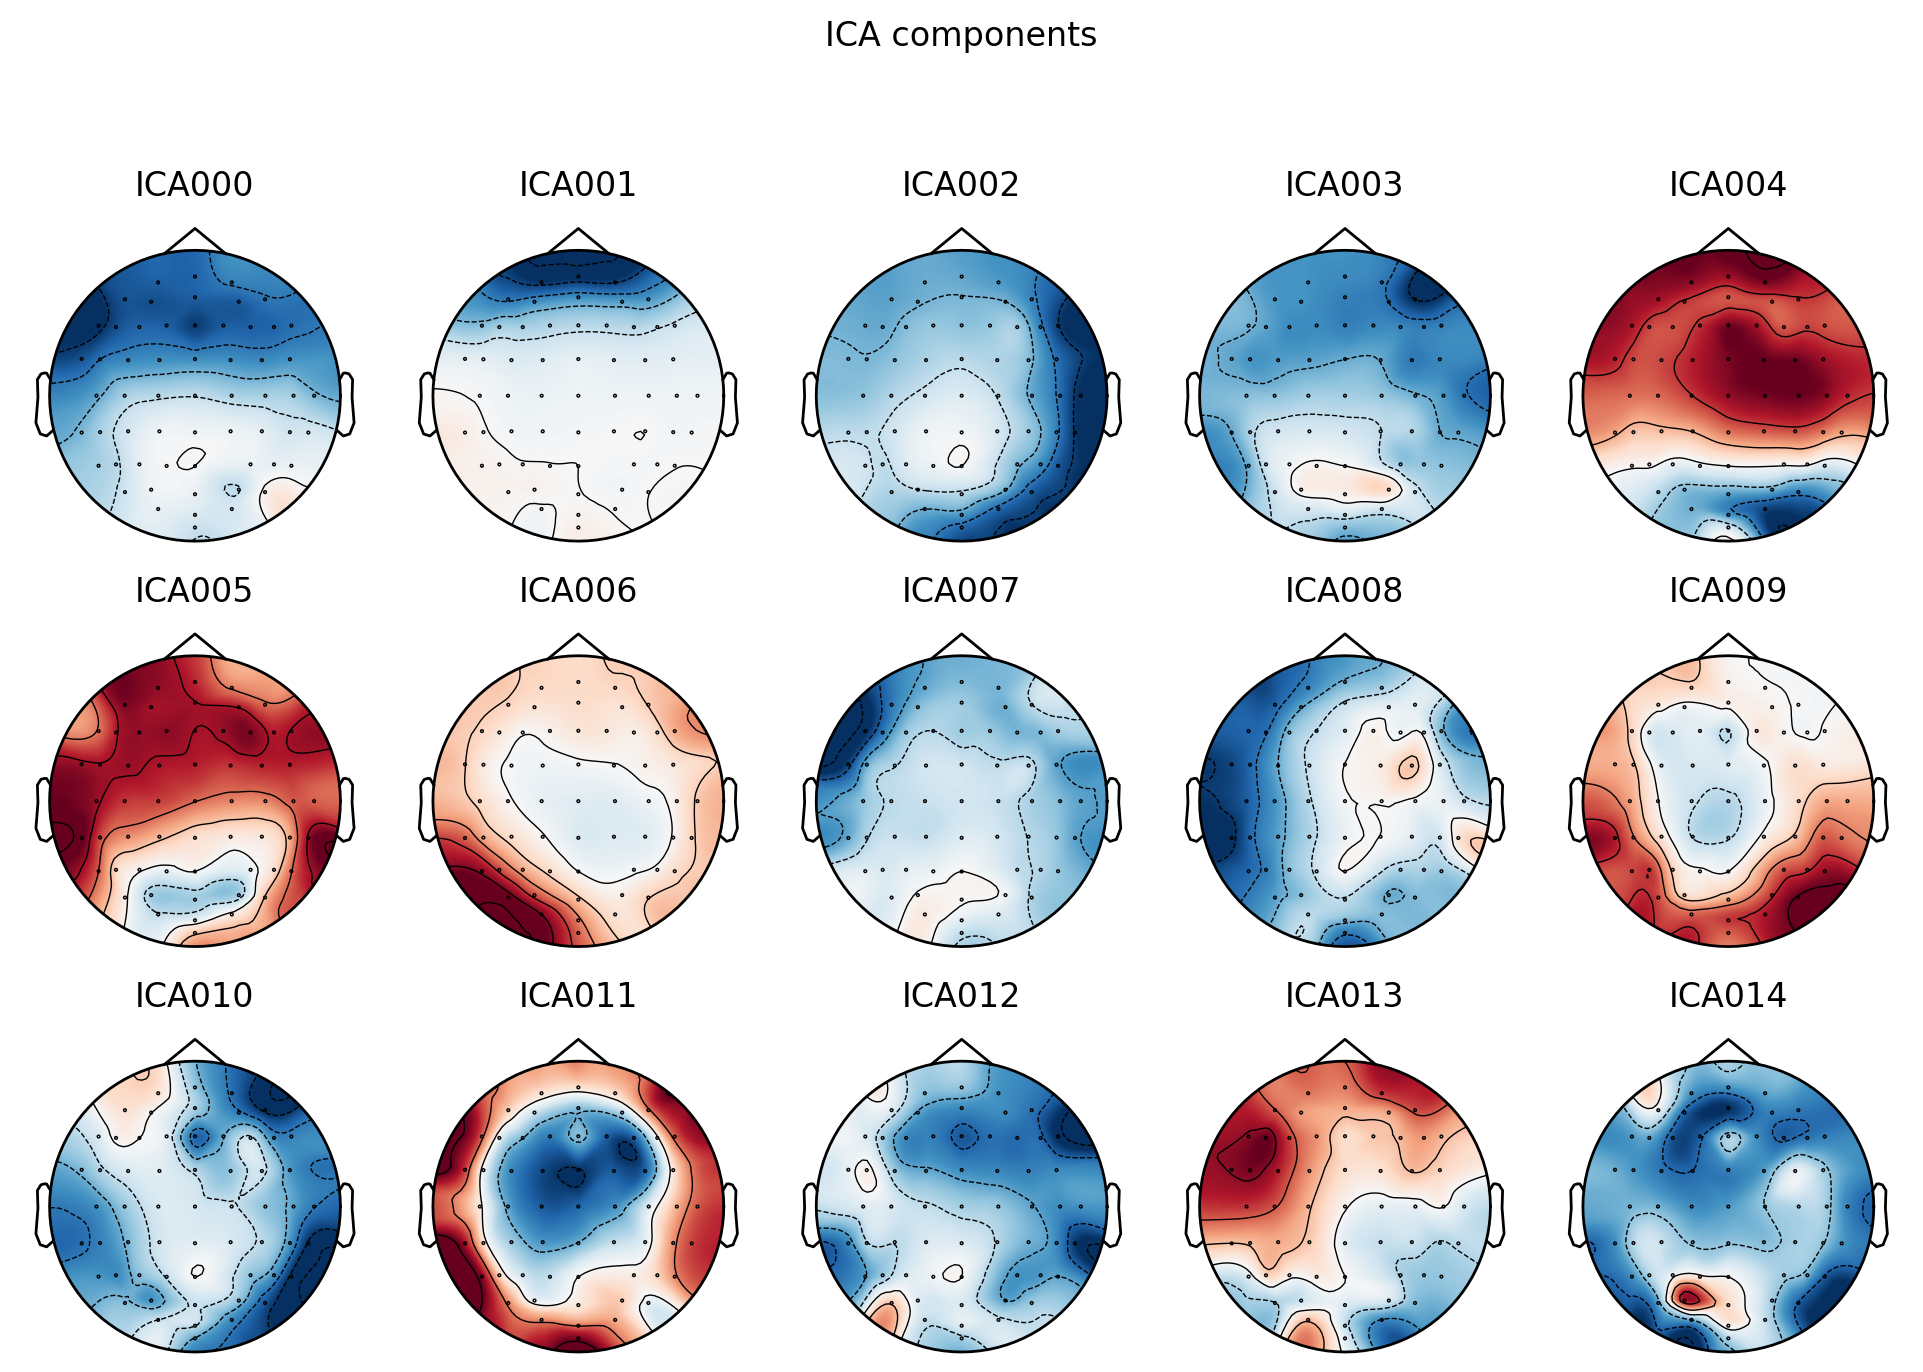

In [427]:
ica.plot_components(inst = epochs_clean,picks=range(15))

Not setting metadata
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-428-5e6ac89eb2f8>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica.plot_sources(epochs_clean, block=False)


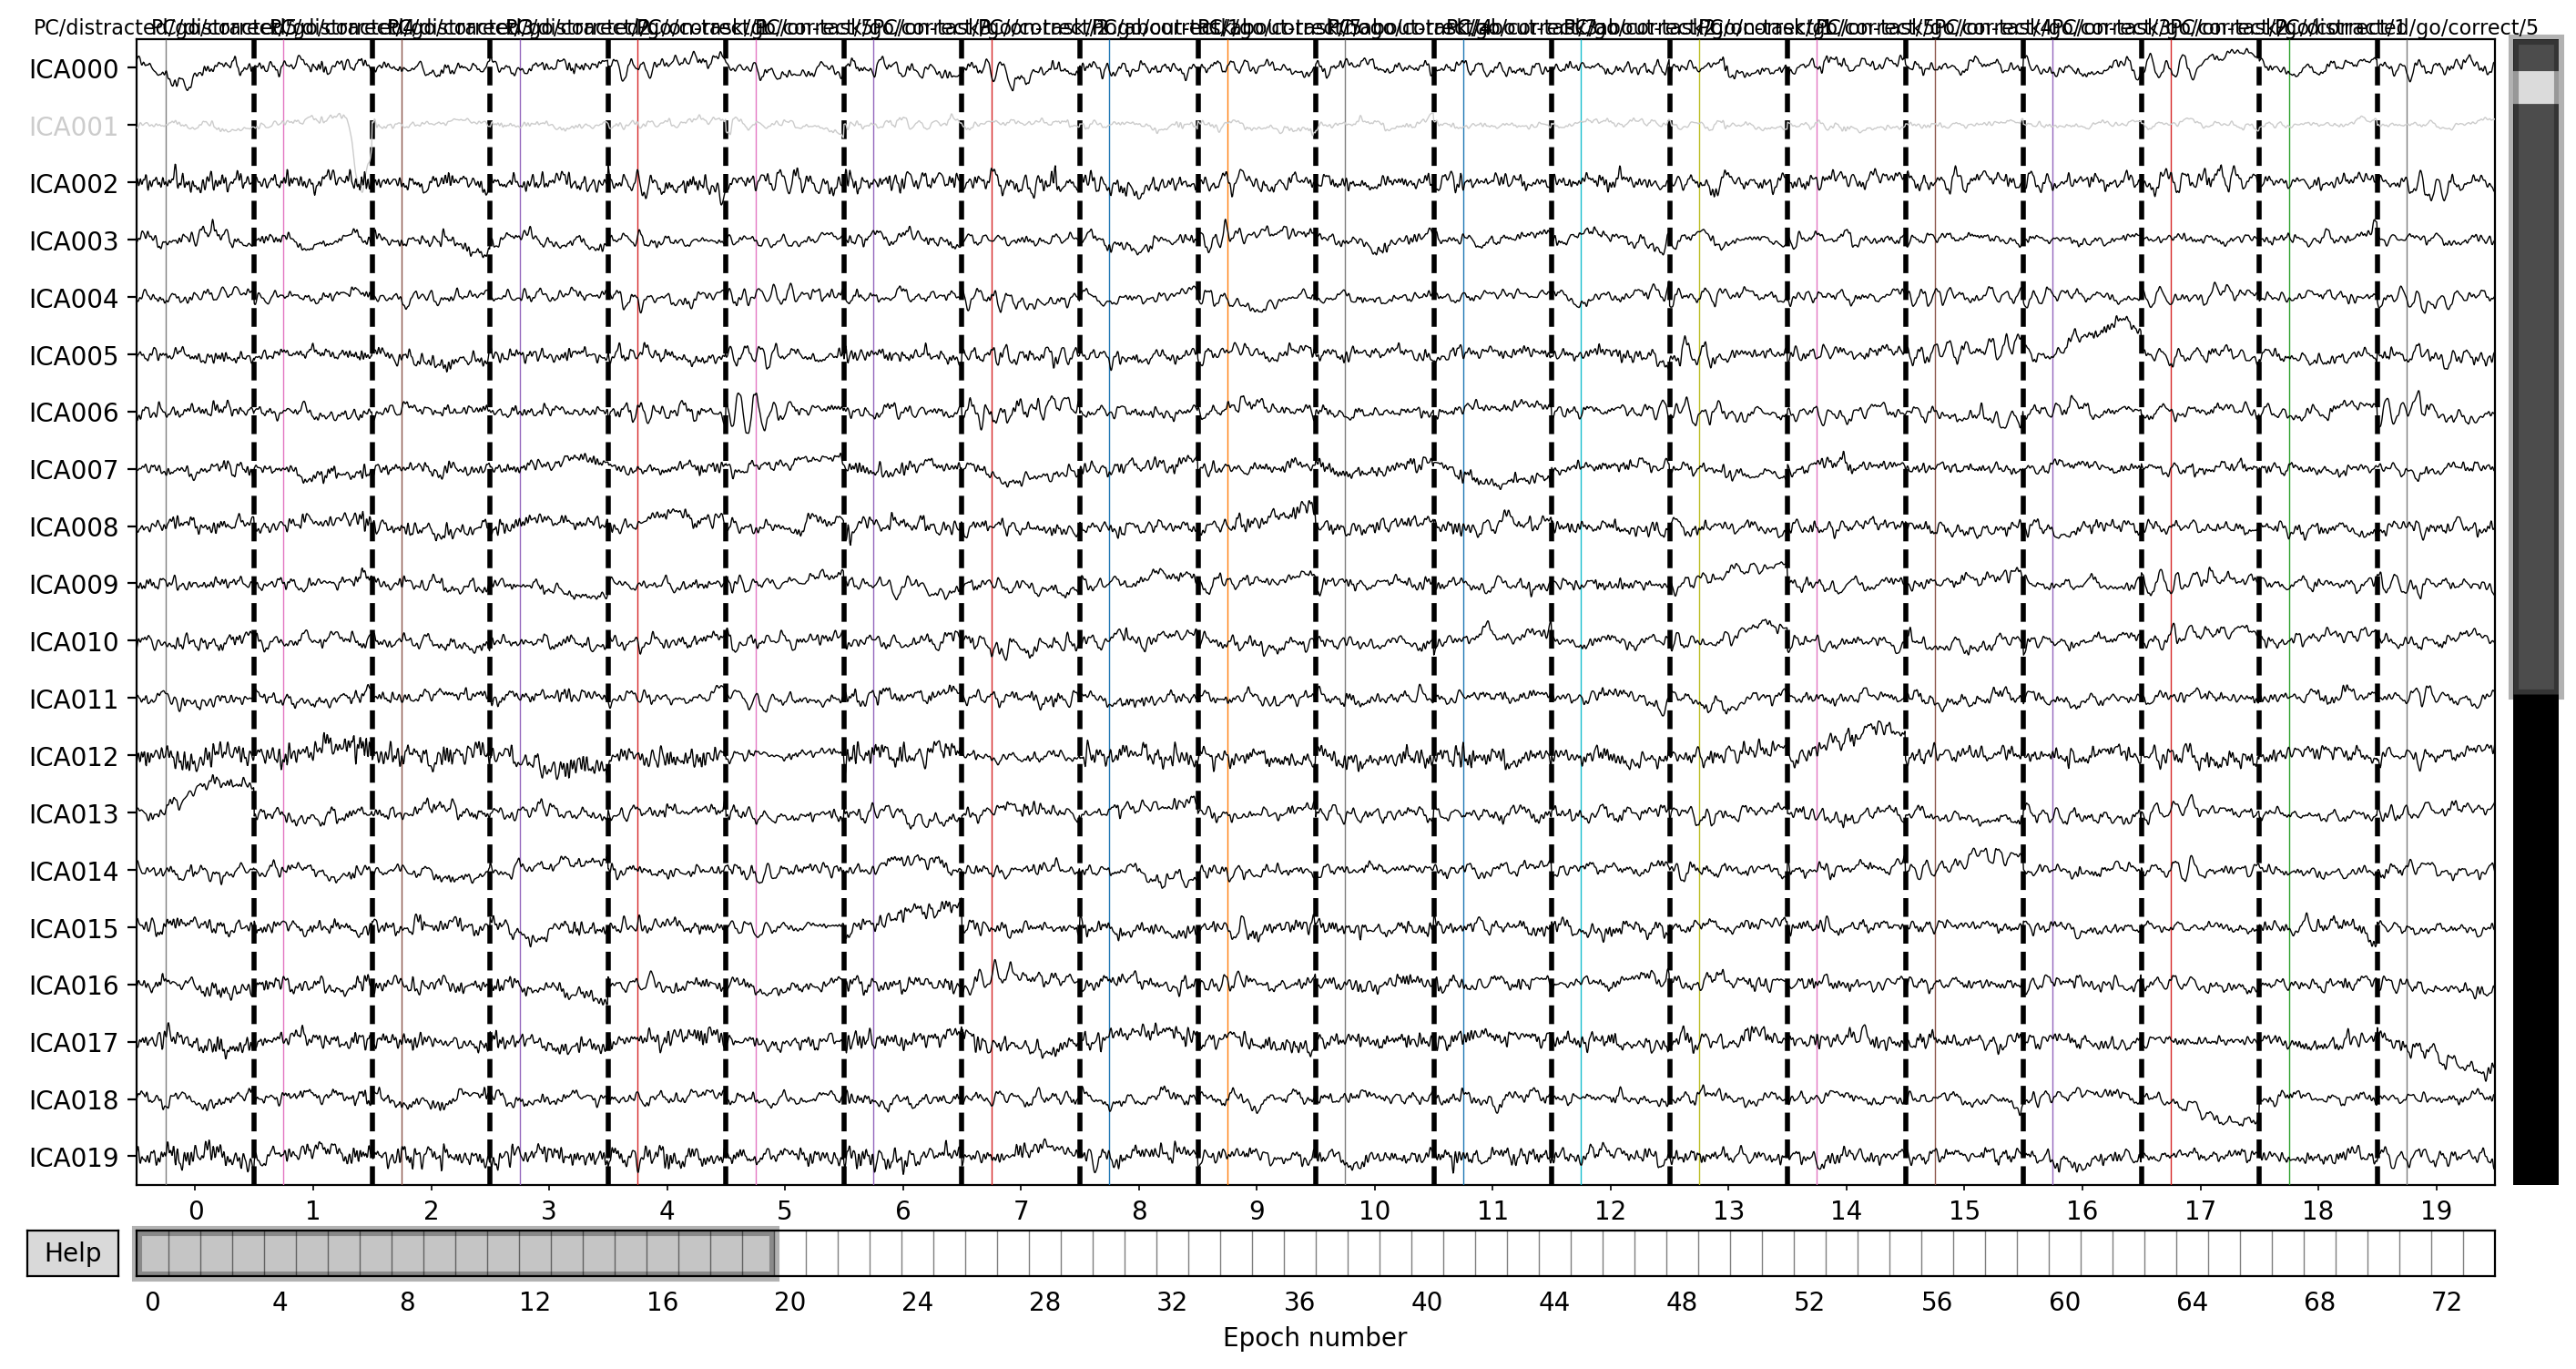

In [428]:
ica.plot_sources(epochs_clean, block=False)

In [429]:
epochs_ica = ica.apply(inst = epochs_clean)
epochs_ica.save(folder + participant + epoch_type + 'ar-ica_epo.fif', overwrite = True)

Applying ICA to Epochs instance
    Transforming to ICA space (31 components)
    Zeroing out 1 ICA component
    Projecting back using 59 PCA components


# Interpolate bad channels <a name="interpolate"></a>


In [430]:
epochs_interpolate = epochs_ica.copy().interpolate_bads()
epochs_interpolate.save(folder + participant + epoch_type + 'ar-interpolate_epo.fif', overwrite = True)

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 5 sensors


# Average Rereference <a name="rereference"></a>

In [431]:
epochs_rereferenced, ref_data = mne.set_eeg_reference(inst = epochs_interpolate, ref_channels = 'average', copy = True)
epochs_rereferenced.save(folder + participant + epoch_type + 'ar-rereferenced_epo.fif', overwrite = True)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


# Subtract ERP

In [432]:
epochs_subtracted = epochs_rereferenced.copy().subtract_evoked()
epochs_subtracted.save(folder + participant + epoch_type + 'ar-subtracted_epo.fif', overwrite = True)

Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: EXG6, EXG5, EXG3, EXG4
[done]


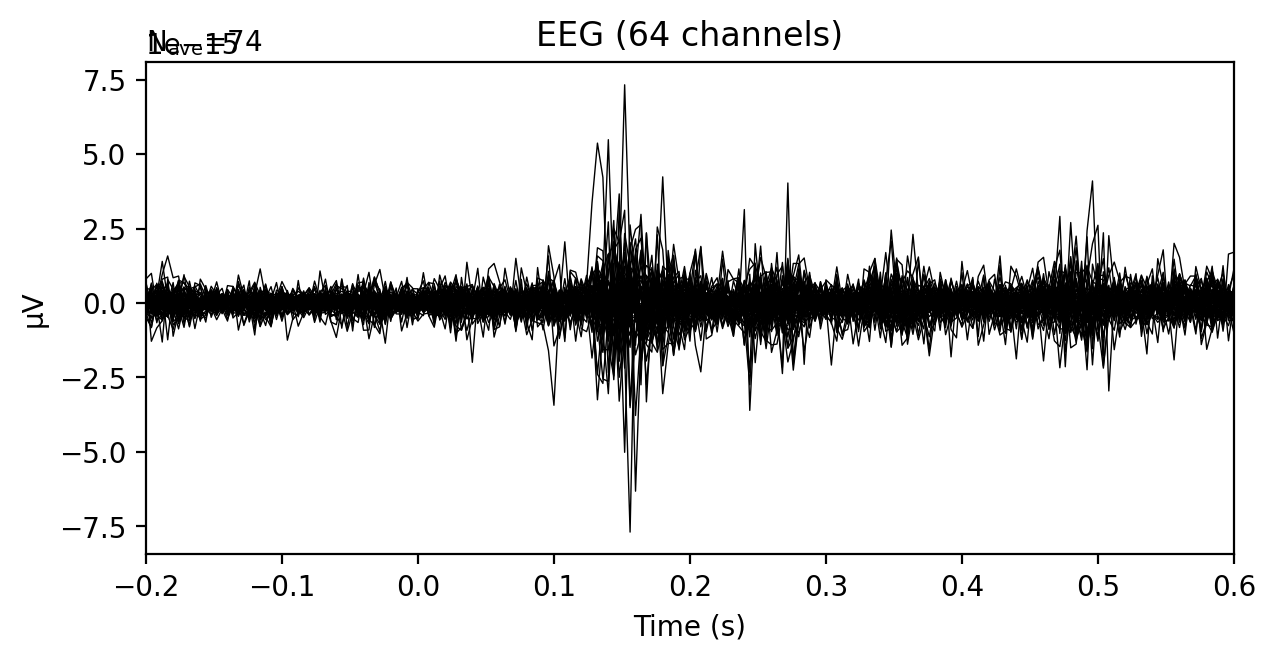

In [433]:
epochs_rereferenced.average().plot()
epochs_subtracted.average().plot()

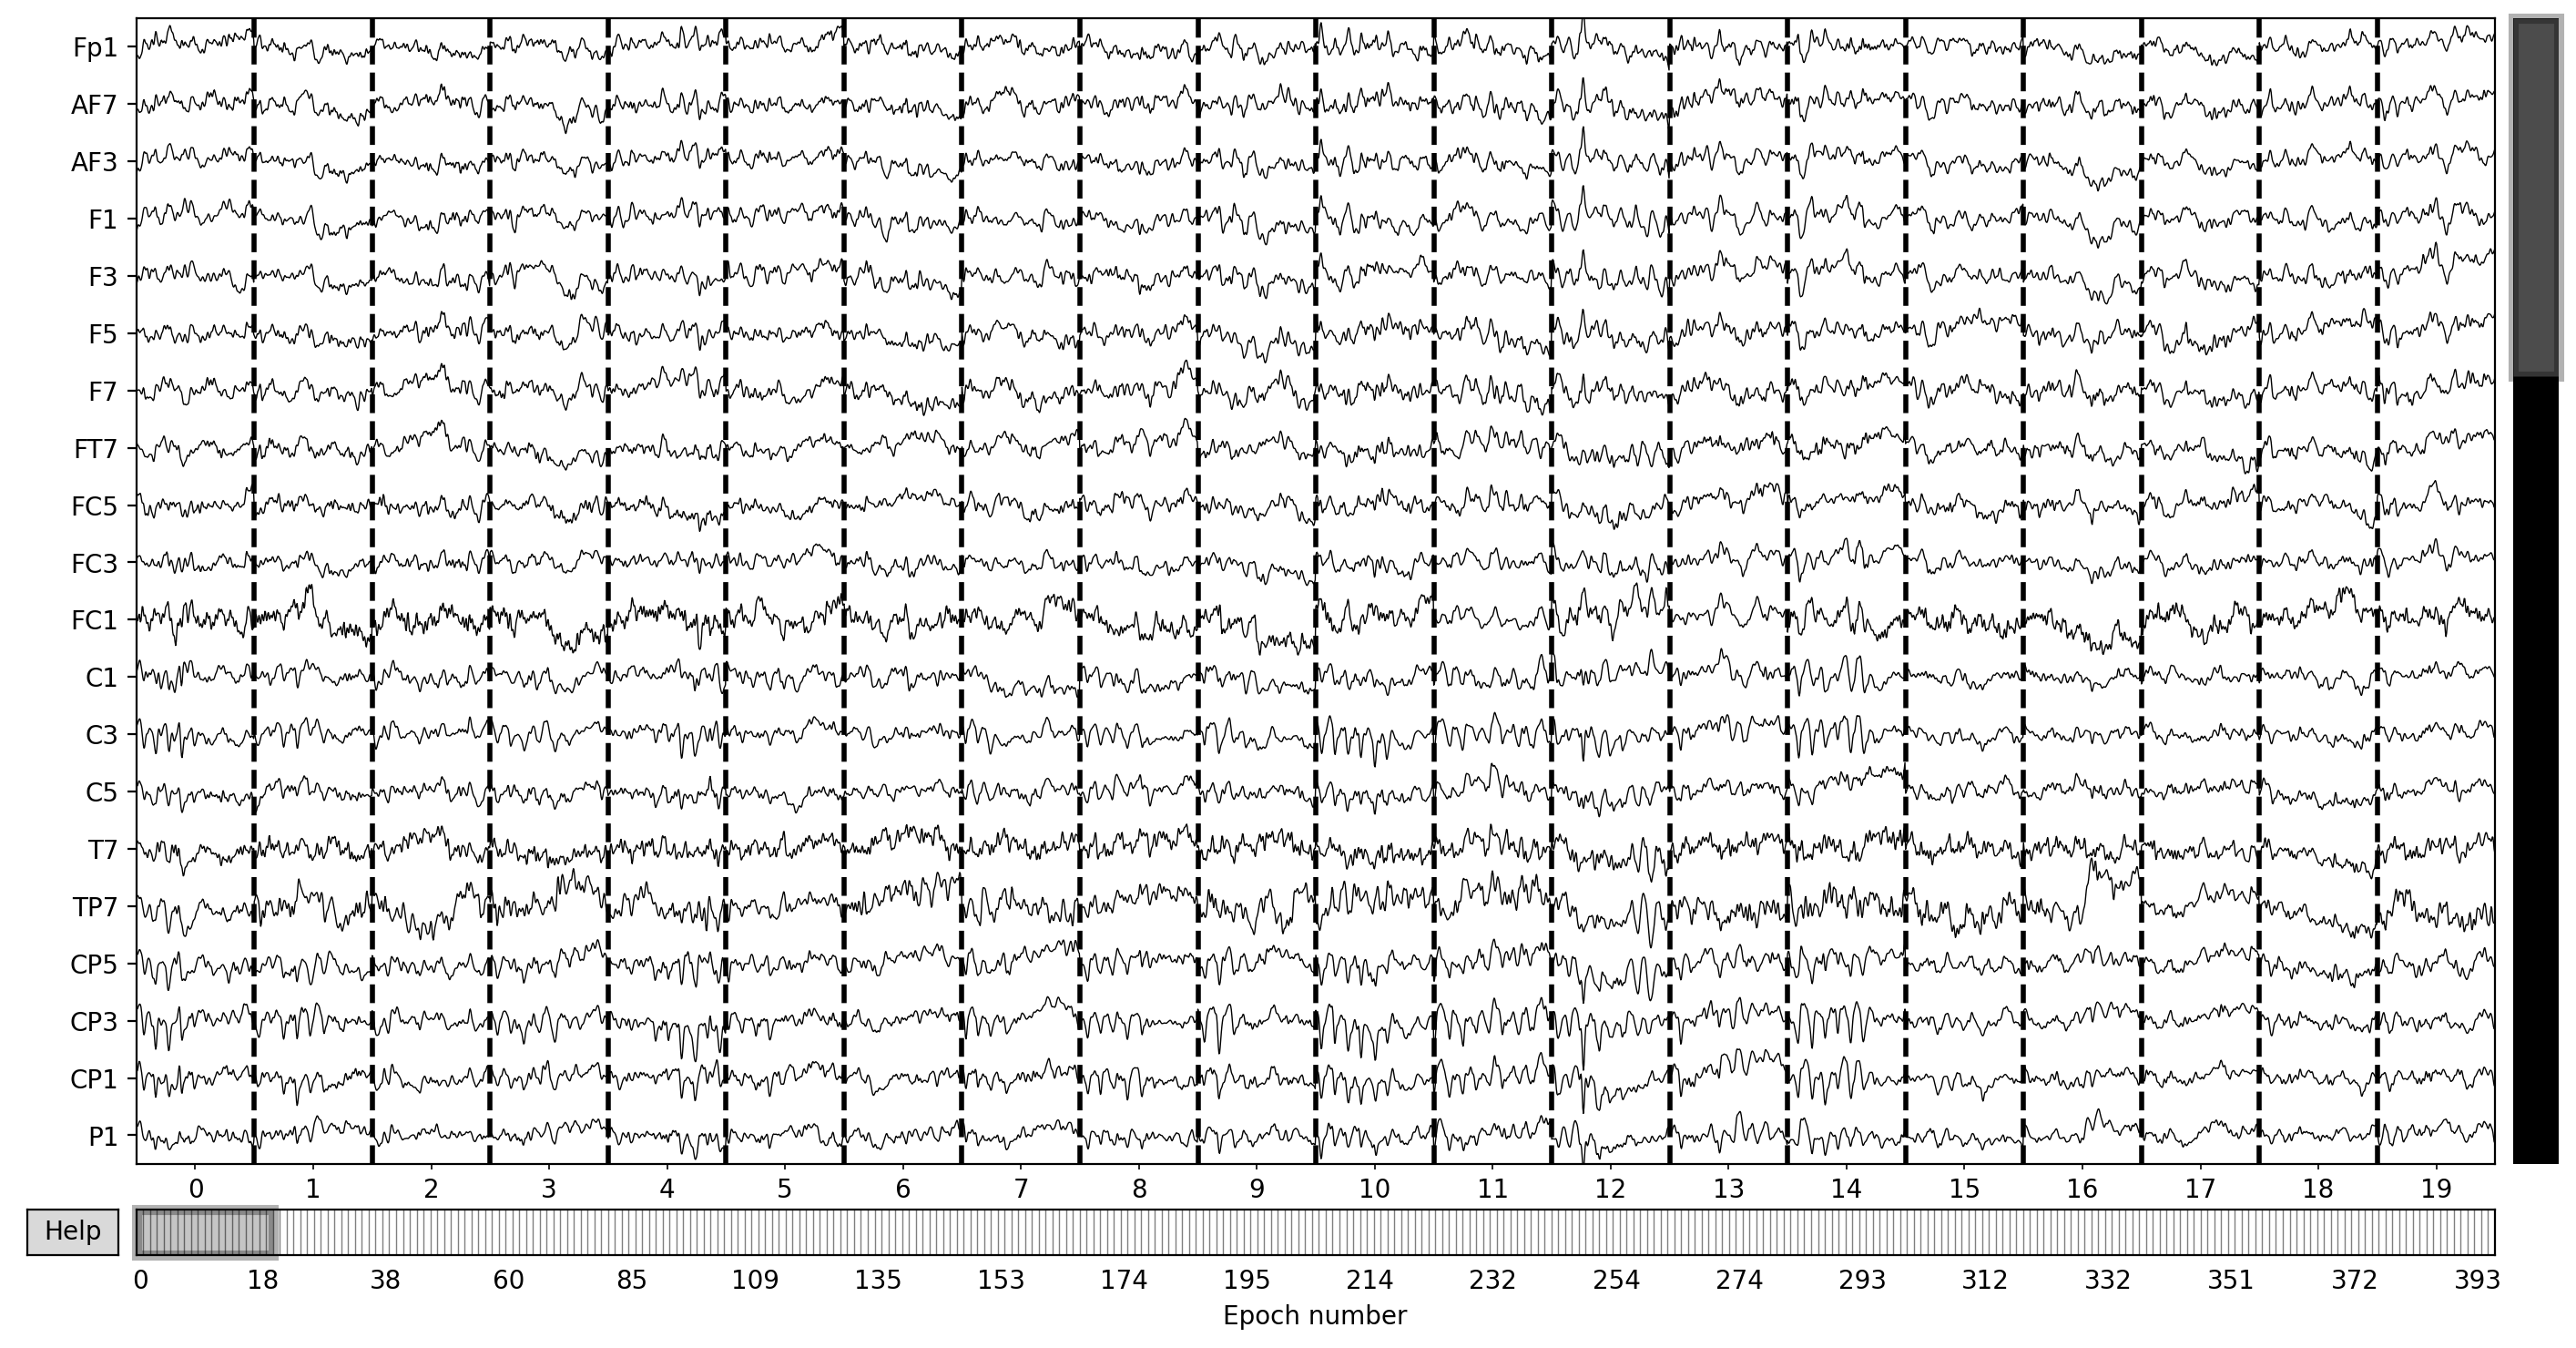

In [407]:
epochs_rereferenced.plot()